In [1]:
"""
Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
Adopting to other backends should be easy, but I have not tested this. 

Usage:
       python capsulenet.py
       python capsulenet.py --epochs 50
       python capsulenet.py --epochs 50 --routings 3
       ... ...
       
Result:
    Validation accuracy > 99.5% after 20 epochs. Converge to 99.66% after 50 epochs.
    About 110 seconds per epoch on a single GTX1070 GPU card
    
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import numpy as np
import tensorflow as tf
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

from keras.utils import np_utils
from keras.utils import to_categorical

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    from utils import plot_log
    plot_log(args.save_dir + '/log.csv', show=True)

    return model


def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=30)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()


def manipulate_latent(model, data, args):
    print('-'*30 + 'Begin: manipulate' + '-'*30)
    x_test, y_test = data
    index = np.argmax(y_test, 1) == args.digit
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = x_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 10, 16])
    x_recons = []
    for dim in range(16):
        for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)

    x_recons = np.concatenate(x_recons)

    img = combine_images(x_recons, height=16)
    image = img*255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + '/manipulate-%d.png' % args.digit)
    print('manipulated result saved to %s/manipulate-%d.png' % (args.save_dir, args.digit))
    print('-' * 30 + 'End: manipulate' + '-' * 30)


def load_mnist():
    PATH=os.getcwd()
    data_path=PATH + '/dataset'
    #data_path='/home/gaurav/Desktop/semproj/Vector-Capsule-Network-for-wild-animal-species-recognition-in-Camera-trap-images.-master/images'
    data_dir_list=sorted(os.listdir(data_path))
    img_data_list=[]
    for dataset in data_dir_list:
        
        img_list=sorted(os.listdir(data_path+'/'+dataset))
        #img_list = [image[2:] for image in img_list]
        print(img_list)
    #      print("loaded the images of dataset -"+"{}\n".format((dataset))
        for img in img_list:
            print(data_path+'/'+dataset+'/'+img)
            input_img=cv2.imread(data_path+'/'+dataset+'/'+img)
            if input_img is not None:             
                input_img_resize=cv2.resize(input_img,(28,28))
                img_data_list.append(input_img_resize)        
            else:                
                print("image not loaded")                                
        img_data=np.array(img_data_list) # Convert to numpy array
        img_data=img_data.astype('float32') # Convert to float
        img_data /= 255 #Normalization 
        mean = np.array([0.485, 0.456, 0.406]) #provided mean
        std = np.array([0.229, 0.224, 0.225]) #provided std
        img_data = (img_data-mean)/std
        

        print(img_data.shape)
        
    num_of_samples =img_data.shape[0]
    
    # Assign lables to the dataset
    labels=np.ones((num_of_samples,),dtype='int64')
    labels[0: 60] = 0
    labels[60: 120] = 1
    labels[120: 178] = 2
    labels[178: 238] = 3
    labels[238: 282] = 4
    labels[282: 323] = 5
    labels[323: 376] = 6
    labels[376: 424] = 7
    labels[424: 483] = 8
    labels[483: 543] = 9
    labels[543: 603] = 10
    labels[603: 659] = 11
    labels[659: 719] = 12
    labels[719: 779] = 13
    labels[779: 837] = 14
    labels[837: 895] = 15
    labels[895: 952] = 16
    labels[952: 997] = 17
    labels[997: 1056] = 18
    labels[1056: 1115] = 19

    # Labels
    names=['Black_footed_Albatross', 'Laysan_Albatross', 'Sooty_Albatross', 'Groove_billed_Ani', 'Crested_Auklet', 'Least_Auklet', 'Parakeet_Auklet', 'Rhinoceros_Auklet', 'Brewer_Blackbird', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Yellow_headed_Blackbird', 'Bobolink', 'Indigo_Bunting', 'Lazuli_Bunting', 'Painted_Bunting', 'Cardinal', 'Spotted_Catbird', 'Gray_Catbird', 'Yellow_breasted_Chat']
    # Convert class labels to one-hot encoding
    Y=np_utils.to_categorical(labels, 20)
    #Shuffle the dataset
    x,y=shuffle(img_data,Y,random_state=2)
    print(x.shape, y.shape)
    #Split the dataset to train and test
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)

    # the data, shuffled and split between train and test sets
    # from keras.datasets import mnist
    # (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    # x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    # y_train = to_categorical(y_train.astype('float32'))
    # y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)


# if __name__ == "__main__":
#     import os
#     import argparse
#     from keras.preprocessing.image import ImageDataGenerator
#     from keras import callbacks

#     # setting the hyper parameters
#     parser = argparse.ArgumentParser(add_help=False)
#     parser.add_argument('--epochs', default=50, type=int)
#     parser.add_argument('--batch_size', default=30, type=int)
#     parser.add_argument('--lr', default=0.001, type=float,
#                         help="Initial learning rate")
#     parser.add_argument('--lr_decay', default=0.9, type=float,
#                         help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
#     parser.add_argument('--lam_recon', default=0.392, type=float,
#                         help="The coefficient for the loss of decoder")
#     parser.add_argument('-r', '--routings', default=3, type=int,
#                         help="Number of iterations used in routing algorithm. should > 0")
#     parser.add_argument('--shift_fraction', default=0.1, type=float,
#                         help="Fraction of pixels to shift at most in each direction.")
#     parser.add_argument('--debug', action='store_true',
#                         help="Save weights by TensorBoard")
#     parser.add_argument('--save_dir', default='./result')
#     parser.add_argument('-t', '--testing', action='store_true',
#                         help="Test the trained model on testing dataset")
#     parser.add_argument('--digit', default=5, type=int,
#                         help="Digit to manipulate")
#     parser.add_argument('-w', '--weights', default=None,
#                         help="The path of the saved weights. Should be specified when testing")
#     parser.add_argument('-f')
#     args = parser.parse_args()
#     print(args)

#     if not os.path.exists(args.save_dir):
#         os.makedirs(args.save_dir)

#     # load data
#     (x_train, y_train), (x_test, y_test) = load_mnist()

#     # define model
#     model, eval_model, manipulate_model = CapsNet(input_shape=x_train.shape[1:],
#                                                   n_class=len(np.unique(np.argmax(y_train, 1))),
#                                                   routings=args.routings)
#     model.summary()

#     # train or test
#     if args.weights is not None:  # init the model weights with provided one
#         model.load_weights(args.weights)
#     if not args.testing:
#         train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)
#     else:  # as long as weights are given, will run testing
#         if args.weights is None:
#             print('No weights are provided. Will test using random initialized weights.')
#         manipulate_latent(manipulate_model, (x_test, y_test), args)
#         test(model=eval_model, data=(x_test, y_test), args=args)


Using TensorFlow backend.


In [2]:
import os
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

# setting the hyper parameters
parser = argparse.ArgumentParser(add_help=False)
parser.add_argument('--epochs', default=50, type=int)
parser.add_argument('--batch_size', default=30, type=int)
parser.add_argument('--lr', default=0.001, type=float,
                    help="Initial learning rate")
parser.add_argument('--lr_decay', default=0.9, type=float,
                    help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
parser.add_argument('--lam_recon', default=0.392, type=float,
                    help="The coefficient for the loss of decoder")
parser.add_argument('-r', '--routings', default=3, type=int,
                    help="Number of iterations used in routing algorithm. should > 0")
parser.add_argument('--shift_fraction', default=0.1, type=float,
                    help="Fraction of pixels to shift at most in each direction.")
parser.add_argument('--debug', action='store_true',
                    help="Save weights by TensorBoard")
parser.add_argument('--save_dir', default='./result')
parser.add_argument('-t', '--testing', action='store_true',
                    help="Test the trained model on testing dataset")
parser.add_argument('--digit', default=3, type=int,
                    help="Digit to manipulate")
parser.add_argument('-w', '--weights', default=None,
                    help="The path of the saved weights. Should be specified when testing")
parser.add_argument('-f')
args = parser.parse_args()
print(args)

if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

# load data
(x_train, y_train), (x_test, y_test) = load_mnist()

# define model
model, eval_model, manipulate_model = CapsNet(input_shape=(28,28,3),
                                              n_class=20,
                                              routings=args.routings)
model.summary()


Namespace(batch_size=30, debug=False, digit=3, epochs=50, f='/home/gaurav/.local/share/jupyter/runtime/kernel-504c4753-81ad-4bd6-8464-b5b95b9aad73.json', lam_recon=0.392, lr=0.001, lr_decay=0.9, routings=3, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)
['Black_Footed_Albatross_0001_796111.jpg', 'Black_Footed_Albatross_0002_55.jpg', 'Black_Footed_Albatross_0003_796136.jpg', 'Black_Footed_Albatross_0005_796090.jpg', 'Black_Footed_Albatross_0006_796065.jpg', 'Black_Footed_Albatross_0007_796138.jpg', 'Black_Footed_Albatross_0008_796083.jpg', 'Black_Footed_Albatross_0009_34.jpg', 'Black_Footed_Albatross_0010_796097.jpg', 'Black_Footed_Albatross_0014_89.jpg', 'Black_Footed_Albatross_0016_796067.jpg', 'Black_Footed_Albatross_0017_796098.jpg', 'Black_Footed_Albatross_0019_796104.jpg', 'Black_Footed_Albatross_0023_796059.jpg', 'Black_Footed_Albatross_0024_796089.jpg', 'Black_Footed_Albatross_0025_796057.jpg', 'Black_Footed_Albatross_0026_796095.jpg', 'Black_Footed_Albatr

/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0025_571.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0028_643.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0029_482.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0033_658.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0034_628.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0035_876.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0037_699.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0039_924.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0040_472.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/002.Laysan_Albatross/Laysan_Albatross_0042_801.jpg
/home/gaur

/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0029_1620.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0031_1588.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0032_1776.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0033_1494.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0035_1591.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0036_1604.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0037_1560.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0040_1715.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Billed_Ani_0044_1731.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/004.Groove_billed_Ani/Groove_Bille

/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/006.Least_Auklet/Least_Auklet_0058_1931.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/006.Least_Auklet/Least_Auklet_0060_795095.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/006.Least_Auklet/Least_Auklet_0063_795134.jpg
(323, 28, 28, 3)
['Parakeet_Auklet_0001_795972.jpg', 'Parakeet_Auklet_0003_795982.jpg', 'Parakeet_Auklet_0004_795921.jpg', 'Parakeet_Auklet_0007_795932.jpg', 'Parakeet_Auklet_0008_795992.jpg', 'Parakeet_Auklet_0010_795995.jpg', 'Parakeet_Auklet_0012_795927.jpg', 'Parakeet_Auklet_0013_795970.jpg', 'Parakeet_Auklet_0015_795966.jpg', 'Parakeet_Auklet_0016_795977.jpg', 'Parakeet_Auklet_0017_795924.jpg', 'Parakeet_Auklet_0019_795987.jpg', 'Parakeet_Auklet_0020_795947.jpg', 'Parakeet_Auklet_0024_2045.jpg', 'Parakeet_Auklet_0025_795975.jpg', 'Parakeet_Auklet_0026_795962.jpg', 'Parakeet_Auklet_0027_795925.jpg', 'Parakeet_Auklet_0028_795944.jpg', 'Parakeet_Auklet_0030_795930.jpg', 'Parakeet_Auklet_0031_795960.jpg', 'Par

/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0004_2345.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0009_2616.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0010_2269.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0012_2691.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0014_2679.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0015_2286.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0016_2225.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0017_2668.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0018_2261.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/009.Brewer_Blackbird/Brewer_Blackbird_0025_2231.jpg


/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0060_4688.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0061_4196.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0062_4233.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0064_4936.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0065_4026.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0066_5070.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0071_3988.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0072_4338.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/010.Red_winged_Blackbird/Red_Winged_Blackbird_0074_4146.jpg
/home/gaurav/Desktop/semproj

/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0012_8443.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0013_8362.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0015_8207.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0017_8511.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0018_8588.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0020_8549.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0023_7325.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Headed_Blackbird_0024_8586.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/012.Yellow_headed_Blackbird/Yellow_Heade

/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0070_10624.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0071_9503.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0074_9311.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0076_11093.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0079_10736.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0081_9439.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0092_10026.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0094_9823.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0097_10861.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0099_9314.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0101_9811.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/013.Bobolink/Bobolink_0

(779, 28, 28, 3)
['Lazuli_Bunting_0001_14916.jpg', 'Lazuli_Bunting_0004_14887.jpg', 'Lazuli_Bunting_0008_15195.jpg', 'Lazuli_Bunting_0009_15163.jpg', 'Lazuli_Bunting_0010_14915.jpg', 'Lazuli_Bunting_0014_14824.jpg', 'Lazuli_Bunting_0015_14690.jpg', 'Lazuli_Bunting_0020_14837.jpg', 'Lazuli_Bunting_0021_14686.jpg', 'Lazuli_Bunting_0025_15079.jpg', 'Lazuli_Bunting_0026_14669.jpg', 'Lazuli_Bunting_0027_14895.jpg', 'Lazuli_Bunting_0028_14950.jpg', 'Lazuli_Bunting_0030_14986.jpg', 'Lazuli_Bunting_0031_15018.jpg', 'Lazuli_Bunting_0032_14778.jpg', 'Lazuli_Bunting_0034_14864.jpg', 'Lazuli_Bunting_0035_14920.jpg', 'Lazuli_Bunting_0037_15021.jpg', 'Lazuli_Bunting_0039_15081.jpg', 'Lazuli_Bunting_0040_14923.jpg', 'Lazuli_Bunting_0041_15152.jpg', 'Lazuli_Bunting_0042_14820.jpg', 'Lazuli_Bunting_0045_14954.jpg', 'Lazuli_Bunting_0046_14787.jpg', 'Lazuli_Bunting_0047_14863.jpg', 'Lazuli_Bunting_0048_14844.jpg', 'Lazuli_Bunting_0052_14618.jpg', 'Lazuli_Bunting_0054_14714.jpg', 'Lazuli_Bunting_0055_1504

/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0029_16530.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0032_16605.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0034_15207.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0036_16563.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0039_15235.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0040_16691.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0044_16557.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0046_16535.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0049_16869.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/016.Painted_Bunting/Painted_Bunting_0050_16670.jpg
/home/gaur

(952, 28, 28, 3)
['Spotted_Catbird_0001_796797.jpg', 'Spotted_Catbird_0002_796827.jpg', 'Spotted_Catbird_0003_796822.jpg', 'Spotted_Catbird_0004_796804.jpg', 'Spotted_Catbird_0005_19411.jpg', 'Spotted_Catbird_0006_796823.jpg', 'Spotted_Catbird_0007_19424.jpg', 'Spotted_Catbird_0008_796789.jpg', 'Spotted_Catbird_0009_796795.jpg', 'Spotted_Catbird_0010_19436.jpg', 'Spotted_Catbird_0011_796815.jpg', 'Spotted_Catbird_0012_796802.jpg', 'Spotted_Catbird_0013_19428.jpg', 'Spotted_Catbird_0014_19425.jpg', 'Spotted_Catbird_0015_796808.jpg', 'Spotted_Catbird_0016_796803.jpg', 'Spotted_Catbird_0018_796800.jpg', 'Spotted_Catbird_0019_796788.jpg', 'Spotted_Catbird_0020_796794.jpg', 'Spotted_Catbird_0021_796798.jpg', 'Spotted_Catbird_0022_796821.jpg', 'Spotted_Catbird_0023_796793.jpg', 'Spotted_Catbird_0024_796791.jpg', 'Spotted_Catbird_0025_796819.jpg', 'Spotted_Catbird_0026_796818.jpg', 'Spotted_Catbird_0027_796796.jpg', 'Spotted_Catbird_0028_796813.jpg', 'Spotted_Catbird_0029_796825.jpg', 'Spotte

/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0125_19833.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0126_19446.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0127_20034.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0129_20987.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0130_20328.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0131_19633.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0134_20596.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0138_20945.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0139_21281.jpg
/home/gaurav/Desktop/semproj2.0/CapsNet/dataset/019.Gray_Catbird/Gray_Catbird_0141_21174.jpg
(1056, 28, 28, 3)
['Yellow_Breasted_Chat_0001_21928.jpg', 'Yellow_Brea



Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  62464       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
____________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/50
29/29 [==============================] - 32s 1s/step - loss: 1.2074 - capsnet_loss: 0.7442 - decoder_loss: 1.1815 - capsnet_acc: 0.0552 - val_loss: 1.0994 - val_capsnet_loss: 0.6228 - val_decoder_loss: 1.2158 - val_capsnet_acc: 0.0807

Epoch 00001: val_capsnet_acc improved from -inf to 0.08072, saving model to ./result/weights-01.h5
Epoch 2/50
29/29 [==============================] - 34s 1s/step - loss: 1.0242 - capsnet_loss: 0.6268 - decoder_loss: 1.0139 - capsnet_acc: 0.0552 - val_loss: 1.0691 - val_capsnet_loss: 0.6185 - val_decoder_loss: 1.1495 - val_capsnet_acc: 0.0628

Epoch 00002: val_capsnet_acc did not improve from 0.08072
Epoch 3/50
29/29 [==============================] - 35s 1s/step - loss: 0.9644 - capsnet_loss: 0.5800 - decoder_loss: 0.9806 - capsnet_acc: 0.0912 - val_loss: 1.0138 - val_capsnet_loss: 0.5708 - val_decoder_loss: 1.1303 - val_capsnet_acc: 0.1435

Epo

29/29 [==============================] - 35s 1s/step - loss: 0.6211 - capsnet_loss: 0.3052 - decoder_loss: 0.8060 - capsnet_acc: 0.6545 - val_loss: 0.8630 - val_capsnet_loss: 0.4756 - val_decoder_loss: 0.9885 - val_capsnet_acc: 0.3184

Epoch 00022: val_capsnet_acc did not improve from 0.33632
Epoch 23/50
29/29 [==============================] - 34s 1s/step - loss: 0.6202 - capsnet_loss: 0.3003 - decoder_loss: 0.8160 - capsnet_acc: 0.6645 - val_loss: 0.8626 - val_capsnet_loss: 0.4732 - val_decoder_loss: 0.9933 - val_capsnet_acc: 0.3318

Epoch 00023: val_capsnet_acc did not improve from 0.33632
Epoch 24/50
29/29 [==============================] - 32s 1s/step - loss: 0.6045 - capsnet_loss: 0.2937 - decoder_loss: 0.7930 - capsnet_acc: 0.6741 - val_loss: 0.8591 - val_capsnet_loss: 0.4718 - val_decoder_loss: 0.9879 - val_capsnet_acc: 0.3318

Epoch 00024: val_capsnet_acc did not improve from 0.33632
Epoch 25/50
29/29 [==============================] - 33s 1s/step - loss: 0.6035 - capsnet_loss


Epoch 00048: val_capsnet_acc did not improve from 0.34978
Epoch 49/50
29/29 [==============================] - 35s 1s/step - loss: 0.5625 - capsnet_loss: 0.2482 - decoder_loss: 0.8019 - capsnet_acc: 0.7975 - val_loss: 0.8561 - val_capsnet_loss: 0.4696 - val_decoder_loss: 0.9860 - val_capsnet_acc: 0.3408

Epoch 00049: val_capsnet_acc did not improve from 0.34978
Epoch 50/50
29/29 [==============================] - 35s 1s/step - loss: 0.5652 - capsnet_loss: 0.2503 - decoder_loss: 0.8032 - capsnet_acc: 0.7972 - val_loss: 0.8563 - val_capsnet_loss: 0.4696 - val_decoder_loss: 0.9863 - val_capsnet_acc: 0.3453

Epoch 00050: val_capsnet_acc did not improve from 0.34978
Trained model saved to './result/trained_model.h5'


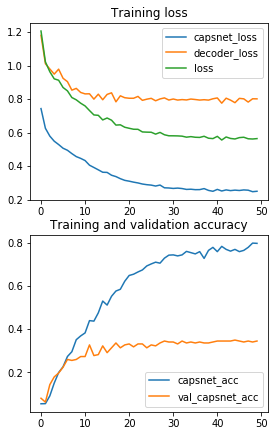

In [3]:
train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)


------------------------------Begin: test------------------------------
Test acc: 0.3452914798206278

Reconstructed images are saved to ./result/real_and_recon.png
------------------------------End: test------------------------------


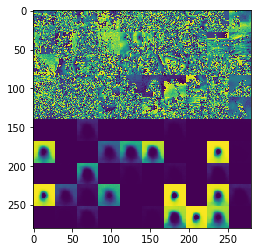

In [4]:
#manipulate_latent(manipulate_model, (x_test, y_test), args)
test(model=eval_model, data=(x_test, y_test), args=args)


In [ ]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return
